<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

<h1><center>Assignment 02</center></h1>
<h2>
Ayushman Anupam (MDS202411)
</h2>

</div>

In [65]:
# importing needed libraries

import csv
import os
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from nltk import bigrams, trigrams

folder_path = "data"
# seed = 2, 9, 13, 42, 123  reandom seed used for splitting data

In [66]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### **Reading the main SMS file**

In [67]:
df_path = os.path.join(folder_path, "SMSSpamCollection")
df = pd.read_csv(df_path, 
                 sep='\t', 
                 quoting=csv.QUOTE_NONE,
                 names = ['label', 'message'])

print("Total number of SMSs:",len(df))
print("\nSample of SMS file \n",df.head(10))

Total number of SMSs: 5574

Sample of SMS file 
   label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...


# **Data Preprocessing**

In [68]:
df['length'] = df['message'].map(lambda text: len(text))
df.head(10)

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147
6,ham,Even my brother is not like to speak with me. ...,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160
8,spam,WINNER!! As a valued network customer you have...,157
9,spam,Had your mobile 11 months or more? U R entitle...,154


### **Checking if message has URls or number**
Most spam has some of url and number embedded in it, we can see this from our result

In [69]:
df['has_url']   = df['message'].str.contains('http')
df['has_number'] = df['message'].str.contains(r'\d')

df.groupby('label')[['has_url', 'has_number']].mean()

,has_url,has_number
label,,
ham,0.000000,0.156619
spam,0.028112,0.947791


### **Exclamation mark and caps ratio of ham vs spam**

In [70]:
df['exclamation_count'] = df['message'].apply(lambda x: x.count('!'))
df['caps_ratio'] = df['message'].apply(
    lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1)
)

df.groupby('label')[['exclamation_count', 'caps_ratio']].mean()

,exclamation_count,caps_ratio
label,,
ham,0.176507,0.05848
spam,0.729585,0.11091


## **Preprocessing SMS text**

In [71]:
# finding sets of english stopwords
stop_words = set(stopwords.words('english'))

# function for preprocessing SMS
def preprocess_text(text):
    tokens = word_tokenize(text)   # Tokenization
    tokens = [token for token in tokens if token not in stop_words]   # Stopword removal
    
    lemmatizer = WordNetLemmatizer()   # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    tokens = [token.lower() for token in tokens]   # Converting all text to lowercase
    tokens = [token for token in tokens if token != '']   # Removing empty strings
    
    return tokens

df['message'] = df['message'].apply(preprocess_text)
df.head()

,label,message,length,has_url,has_number,exclamation_count,caps_ratio
0,ham,"[go, jurong, point, ,, crazy, .., available, b...",111,False,False,0,0.027027
1,ham,"[ok, lar, ..., joking, wif, u, oni, ...]",29,False,False,0,0.068966
2,spam,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",155,False,True,0,0.064516
3,ham,"[u, dun, say, early, hor, ..., u, c, already, ...",49,False,False,0,0.040816
4,ham,"[nah, i, n't, think, go, usf, ,, life, around,...",61,False,False,0,0.032787


### **Replace string length with number of different tokens in preprocessed SMS**

In [72]:
df['length'] = df['message'].apply(len)
df.head(10)

,label,message,length,has_url,has_number,exclamation_count,caps_ratio
0,ham,"[go, jurong, point, ,, crazy, .., available, b...",20,False,False,0,0.027027
1,ham,"[ok, lar, ..., joking, wif, u, oni, ...]",8,False,False,0,0.068966
2,spam,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",32,False,True,0,0.064516
3,ham,"[u, dun, say, early, hor, ..., u, c, already, ...",11,False,False,0,0.040816
4,ham,"[nah, i, n't, think, go, usf, ,, life, around,...",10,False,False,0,0.032787
5,spam,"[freemsg, hey, darling, 's, 3, week, 's, word,...",26,False,True,2,0.047619
6,ham,"[even, brother, like, speak, ., they, treat, l...",11,False,False,0,0.025974
7,ham,"[as, per, request, 'melle, melle, (, oru, minn...",22,False,True,0,0.062500
8,spam,"[winner, !, !, as, valued, network, customer, ...",26,False,True,3,0.076433
9,spam,"[had, mobile, 11, month, ?, u, r, entitled, up...",22,False,True,1,0.090909


### **Encoding label ham as '0' and spam as '1'**

In [73]:
# function for encoding ham as 0 and spam as 1
def encode(text):
    if text == 'spam':
        return 1
    elif text == 'ham':
        return 0
df['label'] = df['label'].apply(encode)

In [ ]:
# saving processed data
df_path = os.path.join(folder_path, "df.csv")
df.to_csv(df_path, index = False)

### Helper functions

In [74]:
# function to split data
def split_data(df, seed=42, train_size=0.7, val_size=0.2, test_size=0.1):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6

    # Train vs (Val + Test)
    train_df, val_test_df = train_test_split(
        df,
        test_size=1 - train_size,
        random_state=seed
    )

    # Val vs Test (stratify again)
    val_df, test_df = train_test_split(
        val_test_df,
        test_size=test_size / (val_size + test_size),
        random_state=seed
    )

    return train_df, val_df, test_df

# function to plot distribution of data
def plot_label_distribution(train_df, val_df, test_df):
    datasets = {
        "Train": train_df,
        "Validation": val_df,
        "Test": test_df
    }

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for ax, (name, data) in zip(axes, datasets.items()):
        counts = data['label'].value_counts().sort_index()

        ax.bar([0], [counts.get(0, 0)], color='blue', label='Ham (0)')
        ax.bar([1], [counts.get(1, 0)], color='red', label='Spam (1)')

        ax.set_xticks([0, 1])
        ax.set_title(name)
        ax.set_xlabel("Label")
        ax.set_ylabel("Count")

    plt.tight_layout()
    plt.show()

# to print summary of data
def print_split_summary(train_df, val_df, test_df):
    
    datasets = {
        "Train": train_df,
        "Validation": val_df,
        "Test": test_df
    }
    
    summary_data = []

    for name, data in datasets.items():
        total = len(data)
        ham = (data['label'] == 0).sum()
        spam = (data['label'] == 1).sum()

        ham_pct = 100 * ham / total
        spam_pct = 100 * spam / total

        summary_data.append({
            "Dataset": name,
            "Total": total,
            "Ham (0)": ham,
            "Spam (1)": spam,
            "Ham %": round(ham_pct, 2),
            "Spam %": round(spam_pct, 2)
        })

    summary_df = pd.DataFrame(summary_data)

    print("\nDataset Split Summary\n")
    print(summary_df.to_string(index=False))
    
    return summary_df

# function to split and save splitted files anf to shoe distribution
def split_and_save_data(df, seed, folder_path):
    """
    Splits dataframe into train/val/test,
    plots and prints distribution statistics in tabular format,
    and saves the splits with seed in filename.
    """
    
    # Split
    train_df, val_df, test_df = split_data(df, seed=seed)
    
    # Plot distribution
    plot_label_distribution(train_df, val_df, test_df)
    
    # Print tabular summary
    summary_df = print_split_summary(train_df, val_df, test_df)
    
    # Create filenames with seed
    train_df_path = os.path.join(folder_path, f"train_df_(seed={seed}).csv")
    validation_df_path = os.path.join(folder_path, f"validation_df_(seed={seed}).csv")
    test_df_path = os.path.join(folder_path, f"test_df_(seed={seed}).csv")
    
    # Save splits
    train_df.to_csv(train_df_path, index=False)
    val_df.to_csv(validation_df_path, index=False)
    test_df.to_csv(test_df_path, index=False)
    
    # (Optional but recommended) Save summary table as well
    summary_path = os.path.join(folder_path, f"split_summary_(seed={seed}).csv")
    summary_df.to_csv(summary_path, index=False)
    
    print(f"\nFiles saved successfully with seed={seed}")
    
    return train_df, val_df, test_df, summary_df


# Splitting for different seed and terminal Commands

### initializing `git` and `dvc` setup

In [75]:
! git init
! dvc init

Initialized empty Git repository in X:/AGDrive/Applied_Machine_Learning/Assignment 02 - Experiment Tracking - google drive as storage/.git/
Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/treeverse/dvc>


In [76]:
! git add .dvc .dvcignore
! git commit -m "Initialize Git and DVC"

[master (root-commit) b267e6a] Initialize Git and DVC
 3 files changed, 6 insertions(+)
 create mode 100644 .dvc/.gitignore
 create mode 100644 .dvc/config
 create mode 100644 .dvcignore


In [77]:
! dvc add data/
! git add data.dvc
! git commit -m "Track initial data"


To track the changes with git, run:

	git add .gitignore data.dvc

To enable auto staging, run:

	dvc config core.autostage true


⠋ Checking graph



[master 88d580a] Track initial data
 1 file changed, 6 insertions(+)
 create mode 100644 data.dvc


In [ ]:
!dvc remote add -d myremote gdrive://1Uz5UdfQnpBY4-Rvs9fkJoZJl7x74mYqM
# googlr folder used for decoupling
!dvc remote list

Setting 'myremote' as a default remote.
myremote        gdrive://1Uz5UdfQnpBY4-Rvs9fkJoZJl7x74mYqM      (default)


In [ ]:
! dvc remote modify myremote gdrive_client_id <.....................>.com
! dvc remote modify myremote gdrive_client_secret <..................>

In [80]:
! dvc push

1 file pushed


In [81]:
! git add .dvc/config
! git commit -m "Configured Google Drive as DVC remote storage (bonus)"

[master a09d3ff] Configured Google Drive as DVC remote storage (bonus)
 1 file changed, 6 insertions(+)


### split_random_seed = 2

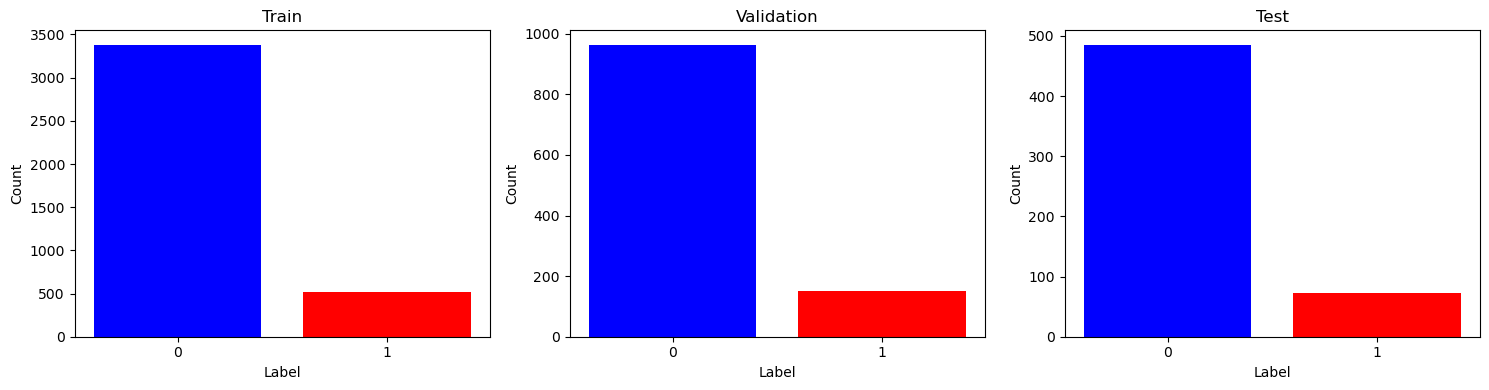


Dataset Split Summary

   Dataset  Total  Ham (0)  Spam (1)  Ham %  Spam %
     Train   3901     3379       522  86.62   13.38
Validation   1115      963       152  86.37   13.63
      Test    558      485        73  86.92   13.08

Files saved successfully with seed=2


In [82]:
train_df, val_df, test_df, summary_df = split_and_save_data(
    df,
    seed=2,
    folder_path=folder_path
)

In [83]:
! dvc add data/
! git add data.dvc


To track the changes with git, run:

	git add data.dvc

To enable auto staging, run:

	dvc config core.autostage true


⠋ Checking graph



In [84]:
! dvc status
! git commit -m "Data split seed=2"
! dvc push

Data and pipelines are up to date.
[master cb8aa67] Data split seed=2
 1 file changed, 3 insertions(+), 3 deletions(-)
1 file pushed


### split_random_seed = 9

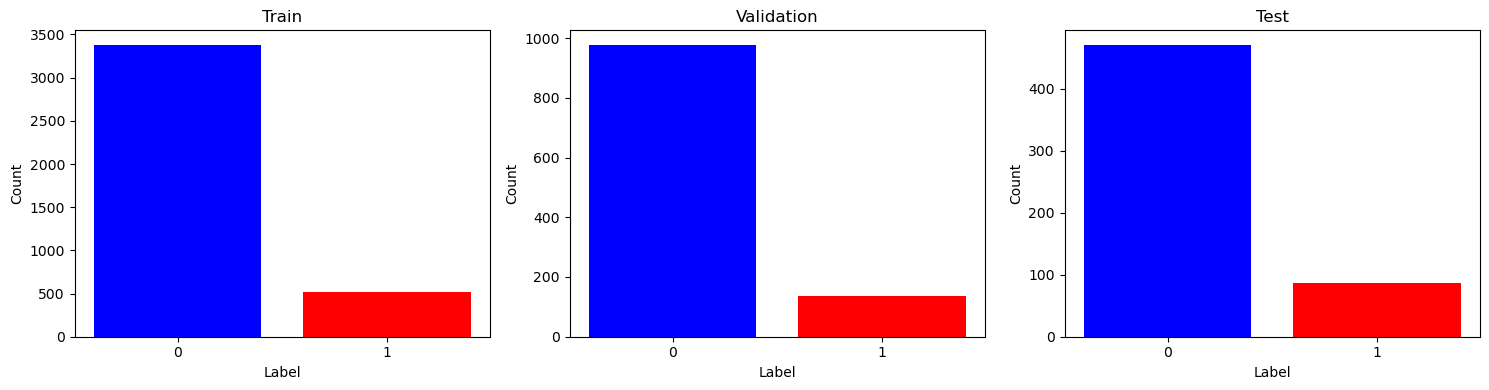


Dataset Split Summary

   Dataset  Total  Ham (0)  Spam (1)  Ham %  Spam %
     Train   3901     3379       522  86.62   13.38
Validation   1115      977       138  87.62   12.38
      Test    558      471        87  84.41   15.59

Files saved successfully with seed=9


In [85]:
train_df, val_df, test_df, summary_df = split_and_save_data(
    df,
    seed=9,
    folder_path=folder_path
)


In [86]:
! dvc add data/
! git add data.dvc


To track the changes with git, run:

	git add data.dvc

To enable auto staging, run:

	dvc config core.autostage true


⠋ Checking graph



In [87]:
! dvc status
! git add data.dvc
! git commit -m "Data split seed=9"

Data and pipelines are up to date.
[master be1f3ea] Data split seed=9
 1 file changed, 3 insertions(+), 3 deletions(-)


### split_random_seed = 13

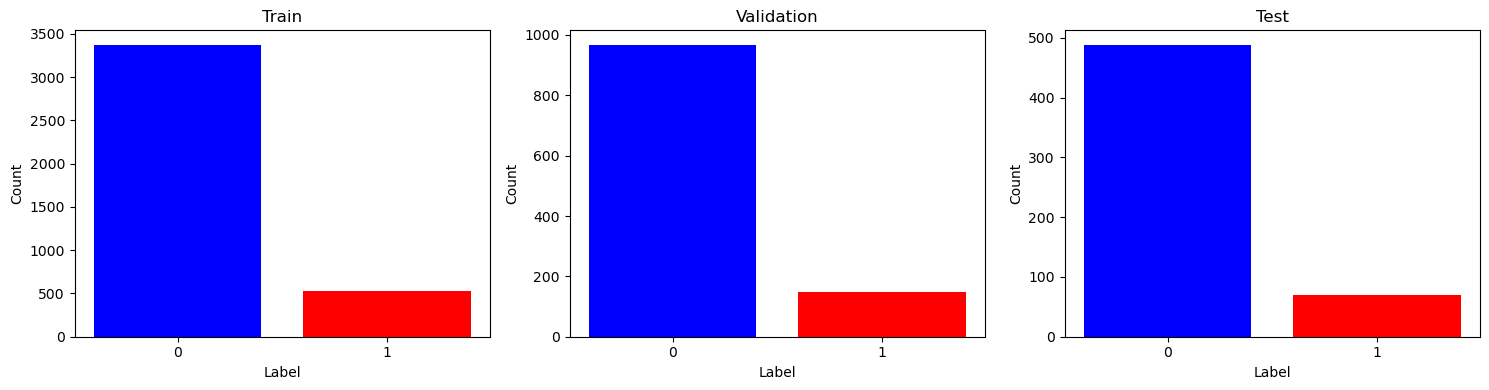


Dataset Split Summary

   Dataset  Total  Ham (0)  Spam (1)  Ham %  Spam %
     Train   3901     3372       529  86.44   13.56
Validation   1115      967       148  86.73   13.27
      Test    558      488        70  87.46   12.54

Files saved successfully with seed=13


In [88]:
train_df, val_df, test_df, summary_df = split_and_save_data(
    df,
    seed=13,
    folder_path=folder_path
)


In [89]:
! dvc add data/
! git add data.dvc


To track the changes with git, run:

	git add data.dvc

To enable auto staging, run:

	dvc config core.autostage true


⠋ Checking graph



In [90]:
! dvc status
! git add data.dvc
! git commit -m "Data split seed=13"

Data and pipelines are up to date.
[master e9c6461] Data split seed=13
 1 file changed, 3 insertions(+), 3 deletions(-)


### split_random_seed = 42

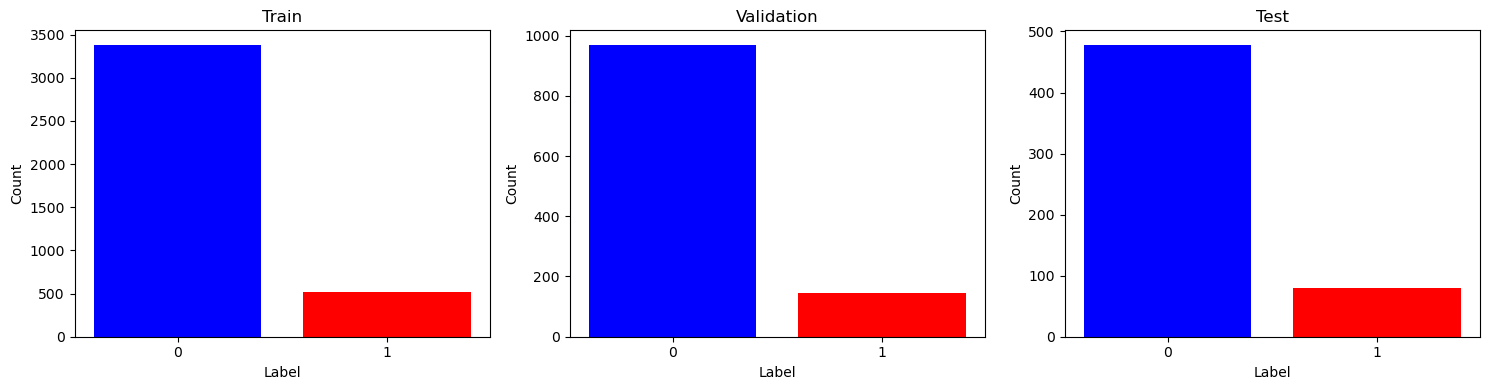


Dataset Split Summary

   Dataset  Total  Ham (0)  Spam (1)  Ham %  Spam %
     Train   3901     3380       521  86.64   13.36
Validation   1115      969       146  86.91   13.09
      Test    558      478        80  85.66   14.34

Files saved successfully with seed=42


In [91]:
train_df, val_df, test_df, summary_df = split_and_save_data(
    df,
    seed=42,
    folder_path=folder_path
)


In [92]:
! dvc add data/
! git add data.dvc


To track the changes with git, run:

	git add data.dvc

To enable auto staging, run:

	dvc config core.autostage true


⠋ Checking graph



In [93]:
! dvc status
! git add data.dvc
! git commit -m "Data split seed=42"

Data and pipelines are up to date.
[master e029afe] Data split seed=42
 1 file changed, 3 insertions(+), 3 deletions(-)


### split_random_seed = 123

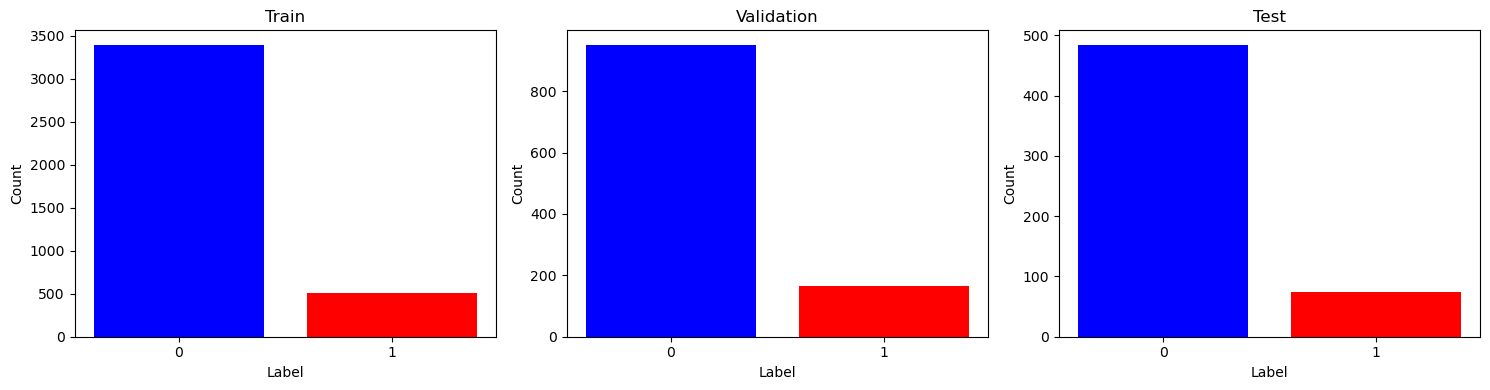


Dataset Split Summary

   Dataset  Total  Ham (0)  Spam (1)  Ham %  Spam %
     Train   3901     3392       509  86.95   13.05
Validation   1115      951       164  85.29   14.71
      Test    558      484        74  86.74   13.26

Files saved successfully with seed=123


In [94]:
train_df, val_df, test_df, summary_df = split_and_save_data(
    df,
    seed=123,
    folder_path=folder_path
)


In [95]:
! dvc add data/
! git add data.dvc


To track the changes with git, run:

	git add data.dvc

To enable auto staging, run:

	dvc config core.autostage true


⠋ Checking graph



In [96]:
! dvc status
! git add data.dvc
! git commit -m "Data split seed=123"

Data and pipelines are up to date.
[master b2584f6] Data split seed=123
 1 file changed, 3 insertions(+), 3 deletions(-)


In [97]:
! git log --oneline

b2584f6 Data split seed=123
e029afe Data split seed=42
e9c6461 Data split seed=13
be1f3ea Data split seed=9
cb8aa67 Data split seed=2
a09d3ff Configured Google Drive as DVC remote storage (bonus)
88d580a Track initial data
b267e6a Initialize Git and DVC
